# Base model and data collection

In [39]:
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load data

In [13]:
#Loading the list of chopin's midi files as stream 
filepath = os.path.join("drive", "MyDrive", "Colab Notebooks", "composer_electronifire", "raw_data","data","chopin")
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = os.path.join(filepath, i)
        midi = converter.parse(tr)
        all_midis.append(midi)

In [15]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 63429


##Data exploration

In [34]:
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 229


In [35]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrence for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrence for a note in Corpus: 261.3711790393013
Most frequent note in Corpus appeared: 1869 times
Least frequent note in Corpus appeared: 1 time


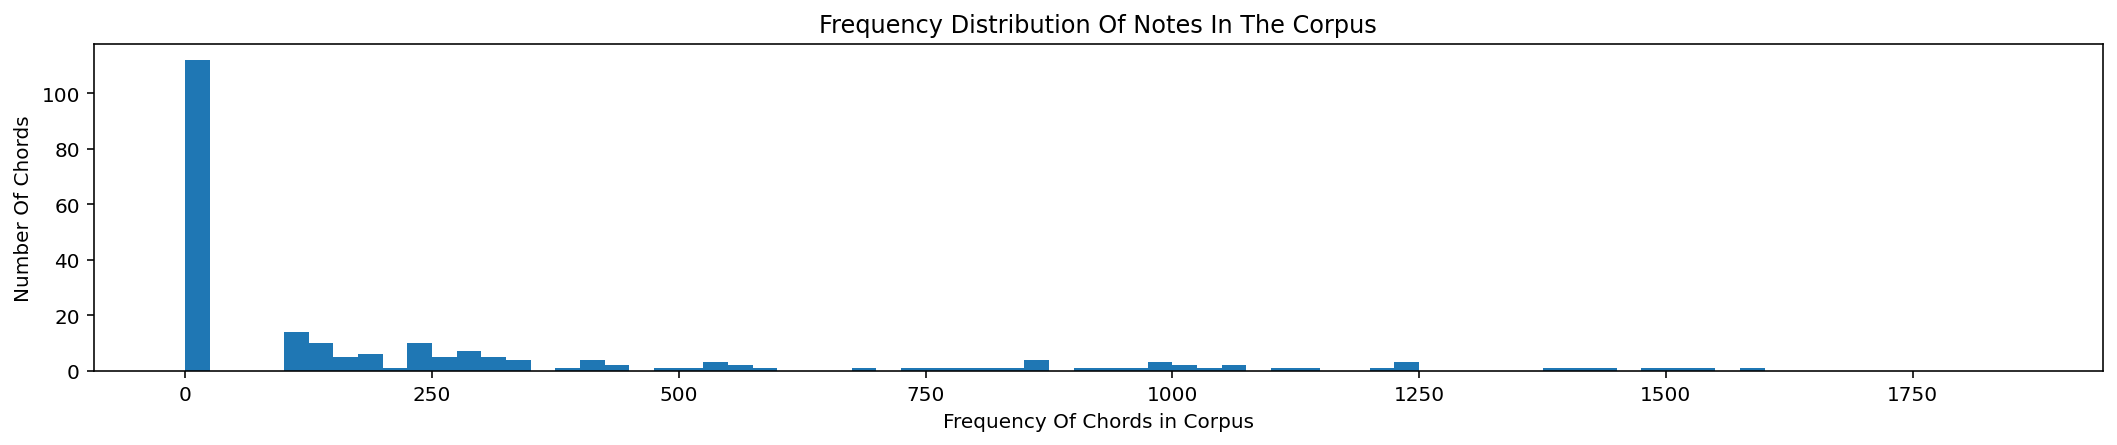

In [36]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3))
bins = np.arange(0,(max(Recurrence)), 25) 
plt.hist(Recurrence, bins=bins)
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [37]:
#Getting a list of rare chords
rare_notes = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        rare_notes.append(key)
        
print("Total number of notes that occur less than 100 times:", len(rare_notes))

Total number of notes that occur less than 100 times: 112


In [38]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_notes:
        Corpus.remove(element)

print("Length of Corpus after elemination of the rare notes:", len(Corpus))

Length of Corpus after elemination of the rare notes: 59426


## Preprocessing

In [26]:
# functions
def note_transformer(note_list, seq_length=40):
  """Function which takes a list of musical notes, 
  and returns X and y where X contains 
  encoded sequences of length X_seq_length of these 
  notes, and y corresponds to the y_seq_length 
  following notes of that sequence"""

  symb = sorted(list(set(note_list)))

  mapping = dict((c, i) for i, c in enumerate(symb))
  reverse_mapping = dict((i, c) for i, c in enumerate(symb))

  features = []
  targets = []
  for i in range(0, len(note_list) - seq_length, 1):
    feature = note_list[i:i + seq_length]
    target = note_list[i + seq_length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
  
  X = (np.reshape(features, (len(targets), length, 1)))/ float(len(symb))
  y = tensorflow.keras.utils.to_categorical(targets) 

  return X, y, reverse_mapping
  

In [27]:
X, y, reverse_mapping = note_transformer(Corpus)

In [28]:
X.shape

(59814, 40, 1)

In [29]:
y.shape

(59814, 229)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Creating the model

In [56]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dense(256))
model.add(Dropout(0.3))
model.add(Dense(128))
model.add(Dropout(0.5))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics='accuracy')

In [57]:
es = EarlyStopping(patience=50, restore_best_weights=True)

In [58]:
history = model.fit(X_train[:5000], y_train[:5000], 
                    batch_size=16, epochs=1000, 
                    verbose=2, callbacks=es, 
                    validation_split=0.2)

Epoch 1/1000
250/250 - 8s - loss: 4.7144 - accuracy: 0.0247 - val_loss: 4.4761 - val_accuracy: 0.0350 - 8s/epoch - 31ms/step
Epoch 2/1000
250/250 - 3s - loss: 4.4450 - accuracy: 0.0262 - val_loss: 4.3751 - val_accuracy: 0.0310 - 3s/epoch - 12ms/step
Epoch 3/1000
250/250 - 3s - loss: 4.4163 - accuracy: 0.0300 - val_loss: 4.3508 - val_accuracy: 0.0330 - 3s/epoch - 12ms/step
Epoch 4/1000
250/250 - 3s - loss: 4.4113 - accuracy: 0.0310 - val_loss: 4.3575 - val_accuracy: 0.0330 - 3s/epoch - 12ms/step
Epoch 5/1000
250/250 - 3s - loss: 4.4077 - accuracy: 0.0338 - val_loss: 4.3983 - val_accuracy: 0.0330 - 3s/epoch - 12ms/step
Epoch 6/1000
250/250 - 3s - loss: 4.4001 - accuracy: 0.0280 - val_loss: 4.3913 - val_accuracy: 0.0300 - 3s/epoch - 12ms/step
Epoch 7/1000
250/250 - 3s - loss: 4.3993 - accuracy: 0.0325 - val_loss: 4.3848 - val_accuracy: 0.0300 - 3s/epoch - 12ms/step
Epoch 8/1000
250/250 - 3s - loss: 4.4004 - accuracy: 0.0345 - val_loss: 4.4098 - val_accuracy: 0.0290 - 3s/epoch - 12ms/step
